In [1]:
pip install torch-geometric sgp4 networkx matplotlib #Install All The Packages and Dependencies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 12.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Main Block to Train the Model and Get Predictions

Total TLE entries loaded: 100
Total TLE entries loaded: 30


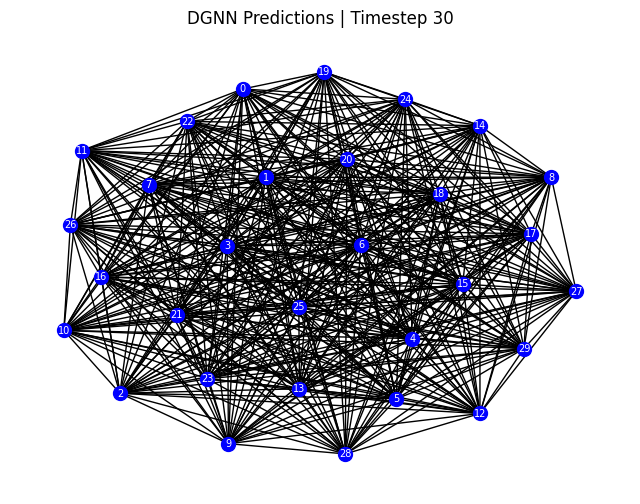

In [2]:
import numpy as np
from sgp4.api import Satrec, jday
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import networkx as nx
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

def load_tle(file):
    # Load TLE data from a file.
    tle_data = []
    satellite_names = []
    with open(file, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]  # Remove empty lines
        for i in range(0, len(lines) - 2, 3):
            if i + 2 < len(lines):
                if not lines[i + 1].startswith("1") or not lines[i + 2].startswith("2"):
                    continue  # Skip invalid TLE entries
                satellite_names.append(lines[i])  # Add satellite name
                tle_data.append((lines[i + 1], lines[i + 2]))  # Add TLE lines
    print(f"Total TLE entries loaded: {len(tle_data)}")
    return tle_data, satellite_names

def propagate_tle(tle_data, timesteps=60):
    # Propagate satellite positions using TLE data over a series of timesteps.
    frames = []
    for tle in tle_data:
        sat = Satrec.twoline2rv(tle[0], tle[1])  # Create a satellite object
        frame = []
        jd, fr = jday(2000, 1, 1, 0, 0, 0)  # Julian date for epoch

        for t in range(timesteps):
            jd_timestep = jd + t * (1)  # Increment Julian date by 1 day per step
            _, position, _ = sat.sgp4(jd_timestep, fr)  # Propagate satellite position
            if position:
                frame.append(position)
            else:
                frame.append([None, None, None])  # Handle propagation errors
        frames.append(frame)

    return np.array(frames)


def prepare_graph_data(frames):
    # Convert satellite position data into graph structures.
    graphs = []
    num_timestamps = frames.shape[1]

    for t in range(num_timestamps):
        positions_at_timestep = frames[:, t]  # Get positions at timestep t
        num_nodes = len(positions_at_timestep)

        edge_index = torch.tensor(
            [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
            dtype=torch.long
        ).t().contiguous()  # Create fully connected edges excluding self-loops

        x = torch.tensor(positions_at_timestep, dtype=torch.float)  # Node features
        graphs.append(Data(x=x, edge_index=edge_index))  # Create graph object

    return graphs

class DGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First GCN layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Second GCN layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))  # Apply ReLU activation after first layer
        x = self.conv2(x, edge_index)  # Output layer
        return x

def train_model(graphs, epochs=100):
    # Train the DGNN model on the prepared graph data.
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DGNN(input_dim=3, hidden_dim=16, output_dim=3).to(device)  # Initialize model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Adam optimizer
    criterion = torch.nn.MSELoss()  # Mean Squared Error loss

    model.train()
    for epoch in range(epochs):
        for graph in graphs:
            graph = graph.to(device)
            optimizer.zero_grad()  # Clear gradients
            output = model(graph)  # Forward pass
            loss = criterion(output, graph.x)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update model parameters
    return model

def generate_predictions(model, graphs):
    # Generate predictions for a set of graphs using a trained model.
    model.eval()
    with torch.no_grad():
        predictions = []
        for i, graph in enumerate(graphs):
            output = model(graph).cpu().numpy()  # Get predictions and move to CPU
            predictions.append(output)
    return np.array(predictions)

def create_graph_animation(frames, satellite_names, title, save_path, collision_threshold=1.0):
    # Create an animation visualizing satellite positions and potential collisions.
    collision_detected = False

    def create_graph(frames, timestep):
        nonlocal collision_detected
        G = nx.Graph()

        for i, pos in enumerate(frames[timestep]):
            if None not in pos:
                G.add_node(i, pos=pos, name=satellite_names[i])  # Add node with position
                for j in range(i + 1, len(frames[timestep])):
                    if None not in frames[timestep][j]:
                        distance = np.linalg.norm(np.array(pos) - np.array(frames[timestep][j]))
                        if distance < collision_threshold:  # Check collision threshold
                            print(f"Collision detected between {satellite_names[i]} and {satellite_names[j]} at timestep {timestep}")
                            collision_detected = True
                        G.add_edge(i, j)  # Add edge between satellites

        return G

    def animate(timestep):
        ax.clear()
        if timestep >= len(frames) - 1:
            if not collision_detected:
                print("No collision detected in the entire animation.")
            return
        G = create_graph(frames, timestep)
        pos = nx.spring_layout(G)  # Compute positions for visualization
        nx.draw(G, pos, ax=ax, with_labels=True, node_size=100, node_color="blue", edge_color="black", font_color='white', font_size=7)

        ax.set_title(f"{title} | Timestep {timestep + 1}")

    fig, ax = plt.subplots(figsize=(8, 6))
    ani = FuncAnimation(fig, animate, frames=min(frames.shape[1], len(frames)), interval=200)  # Create animation
    ani.save(save_path, writer="ffmpeg", fps=4)  # Save animation as a video file

# Load training TLE data
tle_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")
frames = propagate_tle(tle_data, timesteps=40)  # Propagate positions

# Prepare graph data for training
graphs = prepare_graph_data(frames)

# Train the DGNN model
model = train_model(graphs, epochs=100)

# Load test TLE data for prediction
tle_test_data, satellite_names = load_tle("/kaggle/input/short-dataset/Short Data.txt")
test_frames = propagate_tle(tle_test_data, timesteps=40)

test_graphs = prepare_graph_data(test_frames)
frame_list = generate_predictions(model, test_graphs)  # Generate predictions

# Create and save animation of predictions
create_graph_animation(frame_list, satellite_names, "DGNN Predictions", "dgnn_predictions.mp4")


Training and Testing with Same Data to Generate Metrics

In [3]:
# Import necessary libraries for satellite propagation, machine learning, graph processing, and visualization
import numpy as np
from sgp4.api import Satrec, jday
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Function to propagate TLE data over a set number of timesteps (default 40)
def propagate_tle(tle_data, timesteps=40):
    frames = []  # List to store satellite positions over time
    for tle in tle_data:
        # Parse the TLE data into satellite object
        sat = Satrec.twoline2rv(tle[0], tle[1])
        frame = []  # List to store positions of a single satellite across timesteps
        jd, fr = jday(2000, 1, 1, 0, 0, 0)  # Julian date for the start time

        for t in range(timesteps):
            # Calculate the new Julian date for each timestep
            jd_timestep = jd + t * (1 / 1440)  # One timestep equals one minute
            _, position, _ = sat.sgp4(jd_timestep, fr)  # Get satellite position for the timestep
            if position:
                frame.append(position)  # Append valid position
            else:
                frame.append([None, None, None])  # Append None if position is unavailable
        frames.append(frame)

    frames = np.array(frames)  # Convert list to numpy array
    frames = np.nan_to_num(frames, nan=0.0)  # Replace NaN values with 0.0
    return frames  # Return the satellite positions over time

# Function to normalize satellite positions using StandardScaler
from sklearn.preprocessing import StandardScaler

def normalize_frames(frames):
    # Flatten the frames for normalization
    scaler = StandardScaler()
    frames_reshaped = frames.reshape(-1, frames.shape[-1])
    frames_normalized = scaler.fit_transform(frames_reshaped)  # Normalize the positions
    return frames_normalized.reshape(frames.shape), scaler  # Return normalized frames and scaler for inverse transformation

# Function to prepare graph data for each timestep from satellite positions
def prepare_graph_data(frames):
    graphs = []  # List to store graph data for each timestep
    num_timestamps = frames.shape[1]  # Number of timesteps

    for t in range(num_timestamps):
        positions_at_timestep = frames[:, t]  # Get the positions of all satellites at this timestep
        num_nodes = len(positions_at_timestep)  # Number of satellites (nodes)

        # Create edge indices for a fully connected graph (edges between all pairs of satellites)
        edge_index = torch.tensor(
            [[i, j] for i in range(num_nodes) for j in range(num_nodes) if i != j],
            dtype=torch.long
        ).t().contiguous()

        # Create feature matrix (positions of satellites as features)
        x = torch.tensor(positions_at_timestep, dtype=torch.float)
        x = torch.nan_to_num(x, nan=0.0)  # Replace NaN with 0.0
        graphs.append(Data(x=x, edge_index=edge_index))  # Append graph data for this timestep

    return graphs  # Return list of graphs for each timestep

# Define the Graph Neural Network (GNN) model
class DGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGNN, self).__init__()
        # Graph Convolution layers
        self.conv1 = GCNConv(input_dim, hidden_dim)  # First layer
        self.conv2 = GCNConv(hidden_dim, output_dim)  # Second layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index  # Extract features (x) and edge indices
        x = torch.nan_to_num(x, nan=0.0)  # Replace NaN with 0.0
        x = F.relu(self.conv1(x, edge_index))  # Apply first graph convolution layer with ReLU activation
        x = self.conv2(x, edge_index)  # Apply second graph convolution layer
        return torch.nan_to_num(x, nan=0.0)  # Return output with NaN replaced by 0.0

# Function to train the GNN model
def train_model(graphs, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
    model = DGNN(input_dim=3, hidden_dim=16, output_dim=3).to(device)  # Initialize model
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Adam optimizer
    criterion = torch.nn.HuberLoss(delta=1.0)  # Huber loss function for robust regression

    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0  # Initialize total loss for the epoch
        for graph in graphs:
            graph = graph.to(device)  # Move graph data to the same device as the model
            optimizer.zero_grad()  # Zero the gradients before backpropagation
            output = model(graph)  # Get predictions from the model
            loss = criterion(output, graph.x)  # Compute loss
            total_loss += loss.item()  # Add loss for this batch
            loss.backward()  # Backpropagation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to avoid exploding gradients
            optimizer.step()  # Update model parameters
    return model  # Return trained model

# Function to generate predictions using the trained model
def generate_predictions(model, graphs):
    model.eval()
    predictions = []
    with torch.no_grad(): 
        for graph in graphs:
            graph = graph.to('cuda' if torch.cuda.is_available() else 'cpu')
            output = model(graph).cpu().numpy()  # Get output from the model and convert to numpy array
            predictions.append(output)  # Append predictions
    predictions = np.array(predictions)  # Convert list to numpy array
    return predictions  # Return predictions

# Load the TLE data
tle_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")

frames = propagate_tle(tle_data, timesteps=40)
frames, scaler = normalize_frames(frames)
graphs = prepare_graph_data(frames)
model = train_model(graphs, epochs=100) # Train the model with the graph data

tle_test_data, satellite_names = load_tle("/kaggle/input/datafortraining/Data.txt")
test_frames = propagate_tle(tle_test_data, timesteps=40)
test_frames = scaler.transform(test_frames.reshape(-1, test_frames.shape[-1])).reshape(test_frames.shape)
test_graphs = prepare_graph_data(test_frames)
predictions = generate_predictions(model, test_graphs)
denormalized_predictions = scaler.inverse_transform(predictions.reshape(-1, 3))
print("Running Complete")

Total TLE entries loaded: 100
Total TLE entries loaded: 100
Running Complete



Overall Average Evaluation Metrics:
  Mean Squared Error (MSE): 0.9987
  Mean Absolute Error (MAE): 0.0975
  Accuracy: 99.0000%
  F1 Score: 1.0000


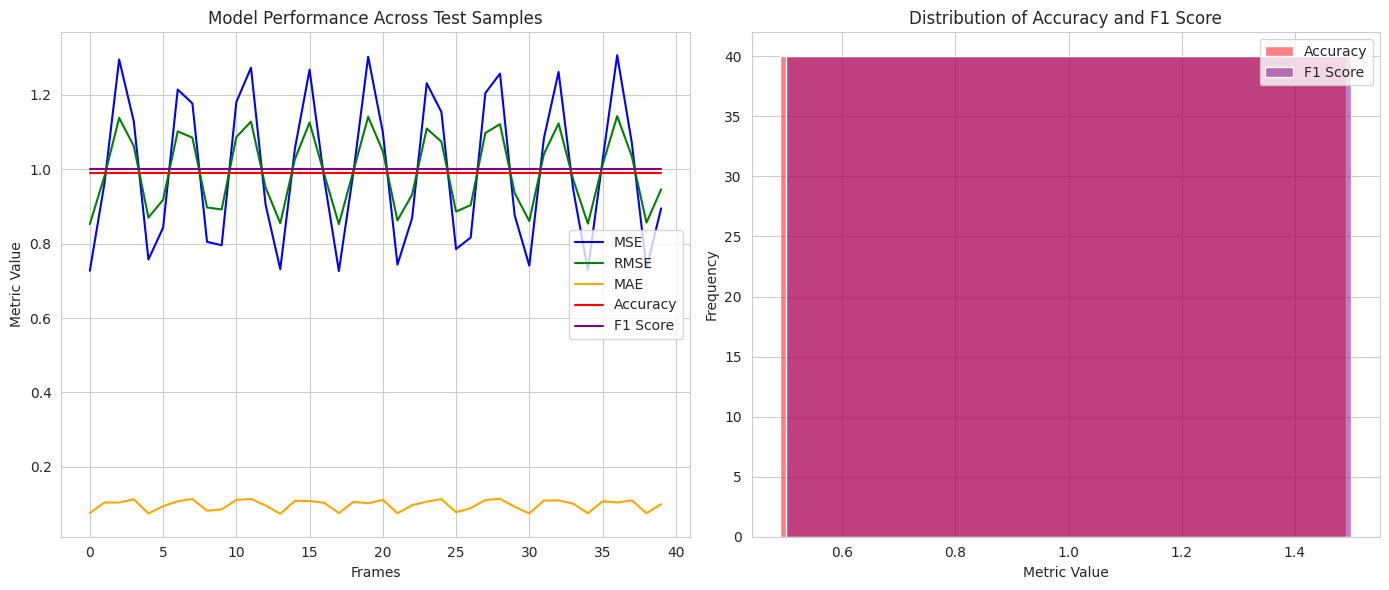

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def evaluate_model(model, graphs, threshold=0.1):
    model.eval()
    with torch.no_grad():
        metrics_per_sample = []
        
        for i, graph in enumerate(graphs):
            predicted_positions = model(graph)
            true_positions = graph.x

            predicted_positions_np = predicted_positions.cpu().numpy()
            true_positions_np = true_positions.cpu().numpy()

            mse = mean_squared_error(true_positions_np, predicted_positions_np)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(true_positions_np, predicted_positions_np)
            
            is_correct = np.all(np.abs(predicted_positions_np - true_positions_np) <= threshold, axis=1)
            accuracy = np.mean(is_correct)
            f1 = f1_score(is_correct, is_correct)

            metrics_per_sample.append((mse, rmse, mae, accuracy, f1))
        
        metrics_per_sample_np = np.array(metrics_per_sample)
        avg_mse = np.mean(metrics_per_sample_np[:, 0])
        avg_rmse = np.mean(metrics_per_sample_np[:, 1])
        avg_mae = np.mean(metrics_per_sample_np[:, 2])
        avg_accuracy = np.mean(metrics_per_sample_np[:, 3])
        avg_f1 = np.mean(metrics_per_sample_np[:, 4])

        print("\nOverall Average Evaluation Metrics:")
        print(f"  Mean Squared Error (MSE): {avg_mse:.4f}")
        print(f"  Mean Absolute Error (MAE): {avg_mae:.4f}")
        print(f"  Accuracy: {avg_accuracy:.4%}")
        print(f"  F1 Score: {avg_f1:.4f}")
        print("=" * 50)

        # Clean up the data before plotting
        metrics_per_sample_np[np.isinf(metrics_per_sample_np)] = np.nan

        plt.figure(figsize=(14, 6))
        sns.set_style('whitegrid')

        plt.subplot(1, 2, 1)
        plt.plot(metrics_per_sample_np[:, 0], label='MSE', color='blue')
        plt.plot(metrics_per_sample_np[:, 1], label='RMSE', color='green')
        plt.plot(metrics_per_sample_np[:, 2], label='MAE', color='orange')
        plt.plot(metrics_per_sample_np[:, 3], label='Accuracy', color='red')
        plt.plot(metrics_per_sample_np[:, 4], label='F1 Score', color='purple')
        plt.title('Model Performance Across Test Samples')
        plt.xlabel('Frames')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.tight_layout()

        plt.subplot(1, 2, 2)
        sns.histplot(metrics_per_sample_np[:, 3][~np.isnan(metrics_per_sample_np[:, 3])], color='red', kde=True, label='Accuracy')
        sns.histplot(metrics_per_sample_np[:, 4][~np.isnan(metrics_per_sample_np[:, 4])], color='purple', kde=True, label='F1 Score')
        plt.title('Distribution of Accuracy and F1 Score')
        plt.xlabel('Metric Value')
        plt.ylabel('Frequency')
        plt.legend()
        
        plt.tight_layout()
        plt.suptitle('', fontsize=16)
        plt.show()

evaluate_model(model, test_graphs, threshold=0.1)
